# SNLI Natural Language Inference Classification

**Stanford Natural Language Inference (SNLI)** is a dataset for natural language inference, where the task is to classify the relationship between a premise and hypothesis as:
- **Entailment** (0): The hypothesis is true given the premise
- **Neutral** (1): The hypothesis might be true given the premise
- **Contradiction** (2): The hypothesis is false given the premise

This notebook will explore different text representation techniques and machine learning models to perform this classification task.

## 1. Import Libraries

In [1]:
# to read and manipulate data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)

# to visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# to use regular expressions for manipulating text data
import re

# to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# nlp libraries
import nltk
nltk.download('stopwords')  # loading the stopwords
nltk.download('wordnet')     # loading the wordnet models used in lemmatization
nltk.download('omw-1.4')     # open multilingual wordnet package

# to remove common stop words
from nltk.corpus import stopwords

# to perform lemmatization
from nltk.stem import WordNetLemmatizer

# to create Bag of Words and TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# to import Word2Vec
from gensim.models import Word2Vec

# to split data into train and test data
from sklearn.model_selection import train_test_split

# to build classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# to compute metrics to evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# for dimensionality reduction visualization
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/proximus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/proximus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/proximus/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Load SNLI Dataset

In [3]:
# loading the SNLI dataset from Hugging Face
from datasets import load_dataset

# loading train and test splits
snli_train = load_dataset("snli", split="train")
snli_test = load_dataset("snli", split="test")

print("Train dataset size:", len(snli_train))
print("Test dataset size:", len(snli_test))

README.md: 0.00B [00:00, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/413k [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Train dataset size: 550152
Test dataset size: 10000


In [4]:
# converting to pandas DataFrame for easier manipulation
train_df = pd.DataFrame(snli_train)
test_df = pd.DataFrame(snli_test)

# creating a copy of the data
data = train_df.copy()

print("Data shape:", data.shape)
print("\nColumn names:", data.columns.tolist())

Data shape: (550152, 3)

Column names: ['premise', 'hypothesis', 'label']


## 3. Exploratory Data Analysis (EDA)

In [5]:
# viewing the first few rows of the dataset
data.head()

,premise,hypothesis,label
0,A person on a horse jumps over a broken down airplane.,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down airplane.,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down airplane.,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


In [6]:
# checking basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\n" + "="*50)
print("Statistical Summary:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550152 entries, 0 to 550151
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   premise     550152 non-null  object
 1   hypothesis  550152 non-null  object
 2   label       550152 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 12.6+ MB
None

Statistical Summary:
               label
count  550152.000000
mean        0.996730
std         0.819796
min        -1.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000


In [7]:
# checking for missing values
print("Missing values in each column:")
print(data.isnull().sum())
print("\n" + "="*50)
print("Percentage of missing values:")
print((data.isnull().sum() / len(data)) * 100)

Missing values in each column:
premise       0
hypothesis    0
label         0
dtype: int64

Percentage of missing values:
premise       0.0
hypothesis    0.0
label         0.0
dtype: float64


In [8]:
# checking label distribution
# Note: label -1 means no gold label (invalid examples)
print("Label Distribution:")
print(data['label'].value_counts())
print("\n" + "="*50)
print("Label Distribution (normalized):")
print(data['label'].value_counts(normalize=True))

Label Distribution:
label
 0    183416
 2    183187
 1    182764
-1       785
Name: count, dtype: int64

Label Distribution (normalized):
label
 0    0.333391
 2    0.332975
 1    0.332206
-1    0.001427
Name: proportion, dtype: float64


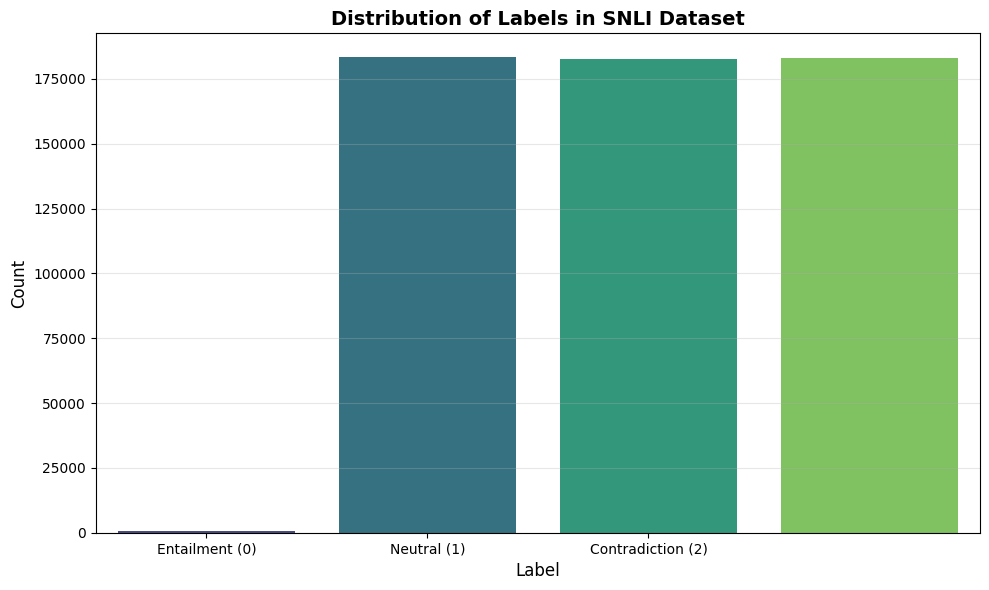

In [9]:
# visualizing label distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='label', palette='viridis')
plt.title('Distribution of Labels in SNLI Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2], ['Entailment (0)', 'Neutral (1)', 'Contradiction (2)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# removing rows with label -1 (invalid labels)
print(f"Original data size: {len(data)}")
data = data[data['label'] != -1].reset_index(drop=True)
print(f"Data size after removing invalid labels: {len(data)}")

Original data size: 550152
Data size after removing invalid labels: 549367


In [11]:
# viewing sample examples from each class
label_names = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

print("Sample Examples from Each Class:\n")
print("="*80)
for label, name in label_names.items():
    print(f"\n{name.upper()} (Label {label}):")
    print("-"*80)
    sample = data[data['label'] == label].iloc[0]
    print(f"Premise: {sample['premise']}")
    print(f"Hypothesis: {sample['hypothesis']}")
    print("="*80)

Sample Examples from Each Class:


ENTAILMENT (Label 0):
--------------------------------------------------------------------------------
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is outdoors, on a horse.

NEUTRAL (Label 1):
--------------------------------------------------------------------------------
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is training his horse for a competition.

CONTRADICTION (Label 2):
--------------------------------------------------------------------------------
Premise: A person on a horse jumps over a broken down airplane.
Hypothesis: A person is at a diner, ordering an omelette.


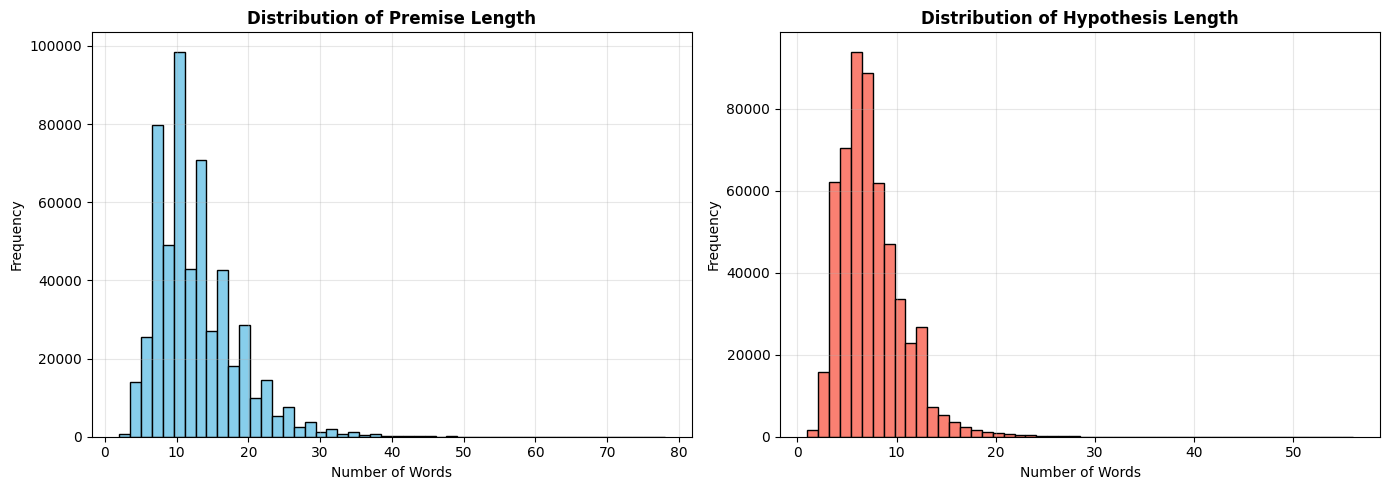

Premise Length Statistics:
count    549367.000000
mean         12.849376
std           5.656857
min           2.000000
25%           9.000000
50%          12.000000
75%          16.000000
max          78.000000
Name: premise_length, dtype: float64

Hypothesis Length Statistics:
count    549367.000000
mean          7.415748
std           3.067807
min           1.000000
25%           5.000000
50%           7.000000
75%           9.000000
max          56.000000
Name: hypothesis_length, dtype: float64


In [12]:
# analyzing text length distribution
data['premise_length'] = data['premise'].fillna("").str.split().str.len()
data['hypothesis_length'] = data['hypothesis'].fillna("").str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(data['premise_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Premise Length', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Words', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].grid(alpha=0.3)

axes[1].hist(data['hypothesis_length'], bins=50, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Hypothesis Length', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Premise Length Statistics:")
print(data['premise_length'].describe())
print("\nHypothesis Length Statistics:")
print(data['hypothesis_length'].describe())

## 4. Text Preprocessing

We will create a combined text column by concatenating premise and hypothesis, then clean the text following these steps:
1. Remove special characters
2. Convert to lowercase
3. Remove extra whitespaces
4. Remove stopwords
5. Perform lemmatization

In [13]:
# creating a combined text column (premise + hypothesis)
data['combined_text'] = data['premise'].fillna("") + " " + data['hypothesis'].fillna("")

# viewing a sample
data.loc[0:3, ['premise', 'hypothesis', 'combined_text']]

,premise,hypothesis,combined_text
0,A person on a horse jumps over a broken down airplane.,A person is training his horse for a competition.,A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.
1,A person on a horse jumps over a broken down airplane.,"A person is at a diner, ordering an omelette.","A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette."
2,A person on a horse jumps over a broken down airplane.,"A person is outdoors, on a horse.","A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse."
3,Children smiling and waving at camera,They are smiling at their parents,Children smiling and waving at camera They are smiling at their parents


### Step 1: Removing Special Characters

In [14]:
# defining a function to remove special characters
def remove_special_characters(text):
    if not isinstance(text, str):
        return ""
    # keep alphanumerics and spaces; remove the rest
    pattern = r"[^A-Za-z0-9\s]"
    new_text = re.sub(pattern, "", text)
    return new_text

# applying the function to remove special characters
data['cleaned_text'] = data['combined_text'].apply(remove_special_characters)

# checking a couple of instances of cleaned data
data.loc[0:3, ['combined_text', 'cleaned_text']]

,combined_text,cleaned_text
0,A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.,A person on a horse jumps over a broken down airplane A person is training his horse for a competition
1,"A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette.",A person on a horse jumps over a broken down airplane A person is at a diner ordering an omelette
2,"A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse.",A person on a horse jumps over a broken down airplane A person is outdoors on a horse
3,Children smiling and waving at camera They are smiling at their parents,Children smiling and waving at camera They are smiling at their parents


### Step 2: Converting to Lowercase

In [15]:
# changing the case of the text data to lower case
data['cleaned_text'] = data['cleaned_text'].str.lower()

data.loc[0:3, ['combined_text', 'cleaned_text']]

,combined_text,cleaned_text
0,A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.,a person on a horse jumps over a broken down airplane a person is training his horse for a competition
1,"A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette.",a person on a horse jumps over a broken down airplane a person is at a diner ordering an omelette
2,"A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse.",a person on a horse jumps over a broken down airplane a person is outdoors on a horse
3,Children smiling and waving at camera They are smiling at their parents,children smiling and waving at camera they are smiling at their parents


### Step 3: Removing Extra Whitespaces

In [16]:
# removing extra whitespaces from the text
# First strip leading/trailing spaces then collapse internal multiple spaces to single
data['cleaned_text'] = data['cleaned_text'].fillna("").str.strip()
data['cleaned_text'] = data['cleaned_text'].str.replace(r"\s+", " ", regex=True)

data.loc[0:3, ['cleaned_text']]

,cleaned_text
0,a person on a horse jumps over a broken down airplane a person is training his horse for a competition
1,a person on a horse jumps over a broken down airplane a person is at a diner ordering an omelette
2,a person on a horse jumps over a broken down airplane a person is outdoors on a horse
3,children smiling and waving at camera they are smiling at their parents


### Step 4: Removing Stopwords

In [17]:
# cache stopwords set once for efficiency
_stopwords = set(stopwords.words('english'))

# defining a function to remove stopwords
def remove_stopwords(text):
    if not isinstance(text, str):
        return ""
    words = text.split()
    # removing English language stopwords
    return ' '.join([word for word in words if word not in _stopwords])

In [18]:
# applying the function to remove stopwords
data['cleaned_text_without_stopwords'] = data['cleaned_text'].apply(remove_stopwords)

# show a preview of original vs cleaned vs no-stopwords
data.loc[0:3, ['combined_text', 'cleaned_text', 'cleaned_text_without_stopwords']]

,combined_text,cleaned_text,cleaned_text_without_stopwords
0,A person on a horse jumps over a broken down airplane. A person is training his horse for a competition.,a person on a horse jumps over a broken down airplane a person is training his horse for a competition,person horse jumps broken airplane person training horse competition
1,"A person on a horse jumps over a broken down airplane. A person is at a diner, ordering an omelette.",a person on a horse jumps over a broken down airplane a person is at a diner ordering an omelette,person horse jumps broken airplane person diner ordering omelette
2,"A person on a horse jumps over a broken down airplane. A person is outdoors, on a horse.",a person on a horse jumps over a broken down airplane a person is outdoors on a horse,person horse jumps broken airplane person outdoors horse
3,Children smiling and waving at camera They are smiling at their parents,children smiling and waving at camera they are smiling at their parents,children smiling waving camera smiling parents


### Step 5: Lemmatization

In [19]:
# initializing lemmatizer
lemmatizer = WordNetLemmatizer()

# defining a function to perform lemmatization
def apply_lemmatizer(text):
    if not isinstance(text, str):
        return ""
    words = text.split()
    # applying the lemmatizer on every word and joining back into a single string
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

# creating a lemmatized version
data['lemmatized_text'] = data['cleaned_text_without_stopwords'].apply(apply_lemmatizer)

data.loc[0:3, ['cleaned_text_without_stopwords', 'lemmatized_text']]

,cleaned_text_without_stopwords,lemmatized_text
0,person horse jumps broken airplane person training horse competition,person horse jump broken airplane person training horse competition
1,person horse jumps broken airplane person diner ordering omelette,person horse jump broken airplane person diner ordering omelette
2,person horse jumps broken airplane person outdoors horse,person horse jump broken airplane person outdoors horse
3,children smiling waving camera smiling parents,child smiling waving camera smiling parent


In [20]:
# tokenizing the lemmatized text for Word2Vec training
data['tokens'] = data['lemmatized_text'].apply(lambda x: x.split())

# viewing sample tokens
print("Sample tokenized text:")
print(data['tokens'].iloc[0])

Sample tokenized text:
['person', 'horse', 'jump', 'broken', 'airplane', 'person', 'training', 'horse', 'competition']


## 5. Feature Representation - Bag of Words (BoW)

In [21]:
# initializing CountVectorizer with top 1000 words
bow_vec = CountVectorizer(max_features=1000)

# applying CountVectorizer on lemmatized text
bow_features = bow_vec.fit_transform(data['lemmatized_text'])
bow_features = bow_features.toarray()

# shape of the feature vector
print("Shape of BoW feature vector:", bow_features.shape)

# getting the top words considered by the BoW model
words = bow_vec.get_feature_names_out()
print("\nFirst 10 words:", words[:10])
print("Last 10 words:", words[-10:])

# converting to DataFrame for better visualization
df_bow = pd.DataFrame(bow_features, columns=bow_vec.get_feature_names_out())
df_bow.head()

Shape of BoW feature vector: (549367, 1000)

First 10 words: ['accordion' 'across' 'adult' 'advertisement' 'african' 'air' 'airplane'
 'airport' 'alley' 'alone']
Last 10 words: ['worker' 'working' 'wrestling' 'writing' 'yard' 'year' 'yellow' 'york'
 'young' 'younger']


,accordion,across,adult,advertisement,african,air,airplane,airport,alley,alone,...,worker,working,wrestling,writing,yard,year,yellow,york,young,younger
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Feature Representation - TF-IDF

In [22]:
# initializing TfidfVectorizer with top 1000 words
tfidf_vec = TfidfVectorizer(max_features=1000)

# applying TfidfVectorizer on lemmatized text
tfidf_features = tfidf_vec.fit_transform(data['lemmatized_text'])
tfidf_features = tfidf_features.toarray()

# shape of the feature vector
print("Shape of TF-IDF feature vector:", tfidf_features.shape)

# converting to DataFrame for better visualization
df_tfidf = pd.DataFrame(tfidf_features, columns=tfidf_vec.get_feature_names_out())
df_tfidf.head()

Shape of TF-IDF feature vector: (549367, 1000)


,accordion,across,adult,advertisement,african,air,airplane,airport,alley,alone,...,worker,working,wrestling,writing,yard,year,yellow,york,young,younger
0,0.0,0.0,0.0,0.0,0.0,0.0,0.416955,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.552779,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.427749,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. Feature Representation - Word2Vec (Custom Trained)

In [23]:
# preparing sentences for Word2Vec training
sentences = data['tokens'].tolist()

# filtering out empty token lists
sentences = [s for s in sentences if isinstance(s, list) and len(s) > 0]

print(f"Total sentences for Word2Vec training: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

Total sentences for Word2Vec training: 549367
Sample sentence: ['person', 'horse', 'jump', 'broken', 'airplane', 'person', 'training', 'horse', 'competition']


In [24]:
# training Word2Vec model with custom parameters
w2v_params = dict(
    vector_size=200,    # embedding size (200 dimensions)
    window=5,           # context window
    min_count=2,        # ignore rare tokens appearing less than 2 times
    workers=4,          # parallel processing
    sg=1,               # 1: skip-gram, 0: CBOW
    negative=10,        # negative sampling
    epochs=10,          # training epochs
    seed=42,            # for reproducibility
)

w2v_model = Word2Vec(sentences=sentences, **w2v_params)

print(f"Word2Vec vocabulary size: {len(w2v_model.wv)}")
print(f"\nSample word vector shape: {w2v_model.wv[w2v_model.wv.index_to_key[0]].shape}")

# showing most similar words to a sample word
if len(w2v_model.wv.index_to_key) > 0:
    sample_word = w2v_model.wv.index_to_key[0]
    print(f"\nMost similar words to '{sample_word}':")
    print(w2v_model.wv.most_similar(sample_word, topn=5))

Word2Vec vocabulary size: 21474

Sample word vector shape: (200,)

Most similar words to 'man':
[('person', 0.7530871629714966), ('woman', 0.6624773144721985), ('glasseswearing', 0.6026204824447632), ('guy', 0.602038562297821), ('madonna', 0.5998896360397339)]


In [25]:
# building document embeddings by averaging token vectors
vector_size = w2v_model.wv.vector_size

def get_doc_vector(tokens):
    """
    Convert a list of tokens to a document vector by averaging word vectors
    """
    if not isinstance(tokens, list) or len(tokens) == 0:
        return np.zeros(vector_size, dtype=np.float32)
    
    # getting vectors for all tokens that exist in vocabulary
    vecs = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
    
    if not vecs:
        return np.zeros(vector_size, dtype=np.float32)
    
    # averaging all word vectors
    return np.mean(vecs, axis=0)

# applying the function to get document vectors
w2v_features = np.vstack(data['tokens'].apply(get_doc_vector).values)

print("Shape of Word2Vec feature vector:", w2v_features.shape)

Shape of Word2Vec feature vector: (549367, 200)


## 8. Feature Representation - GloVe (Pre-trained)

In [26]:
# loading pre-trained GloVe embeddings
glove_path = "../resources/glove.6B/glove.6B.100d.txt"

def load_glove_embeddings(file_path):
    """
    Load pre-trained GloVe embeddings from file
    Returns a dictionary mapping words to their embedding vectors
    """
    embeddings_index = {}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    print(f"Loaded {len(embeddings_index)} word vectors from GloVe")
    return embeddings_index

# loading GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_path)

# checking the dimension of GloVe vectors
sample_word = list(glove_embeddings.keys())[0]
print(f"GloVe vector dimension: {len(glove_embeddings[sample_word])}")

Loaded 400000 word vectors from GloVe
GloVe vector dimension: 100


In [27]:
# creating document vectors using GloVe embeddings
glove_vector_size = 100  # glove.6B.100d has 100 dimensions

def get_glove_doc_vector(tokens):
    """
    Convert a list of tokens to a document vector using GloVe embeddings
    by averaging word vectors
    """
    if not isinstance(tokens, list) or len(tokens) == 0:
        return np.zeros(glove_vector_size, dtype=np.float32)
    
    # getting vectors for all tokens that exist in GloVe vocabulary
    vecs = [glove_embeddings[t] for t in tokens if t in glove_embeddings]
    
    if not vecs:
        return np.zeros(glove_vector_size, dtype=np.float32)
    
    # averaging all word vectors
    return np.mean(vecs, axis=0)

# applying the function to get GloVe document vectors
glove_features = np.vstack(data['tokens'].apply(get_glove_doc_vector).values)

print("Shape of GloVe feature vector:", glove_features.shape)

Shape of GloVe feature vector: (549367, 100)


## 9. Feature Representation - Sentence-BERT

In [28]:
# loading Sentence-BERT model for generating sentence embeddings
from sentence_transformers import SentenceTransformer

# loading the pre-trained model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Sentence-BERT model loaded successfully!")
print(f"Model embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

Sentence-BERT model loaded successfully!
Model embedding dimension: 384


In [29]:
# generating sentence embeddings for the combined text
# using the original combined_text (not lemmatized) for better BERT performance
print("Generating Sentence-BERT embeddings (this may take a few minutes)...")

sbert_features = sbert_model.encode(
    data['combined_text'].tolist(),
    show_progress_bar=True,
    batch_size=32
)

print("Shape of Sentence-BERT feature vector:", sbert_features.shape)

Generating Sentence-BERT embeddings (this may take a few minutes)...


Batches:   0%|          | 0/17168 [00:00<?, ?it/s]

Shape of Sentence-BERT feature vector: (549367, 384)


## 10. Model Training and Evaluation

We will now train classifiers using each feature representation and evaluate their performance.

In [30]:
# preparing labels
y = data['label'].values

print("Label distribution:")
print(pd.Series(y).value_counts())

Label distribution:
0    183416
2    183187
1    182764
Name: count, dtype: int64


In [31]:
# defining a function to train and evaluate models
def train_and_evaluate(X, y, model, feature_name):
    """
    Train a classifier and evaluate its performance
    
    Parameters:
    - X: feature matrix
    - y: labels
    - model: sklearn classifier
    - feature_name: name of the feature representation
    
    Returns:
    - Dictionary containing evaluation metrics
    """
    # splitting data into train and test sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n{'='*80}")
    print(f"Training {model.__class__.__name__} with {feature_name}")
    print(f"{'='*80}")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    
    # training the model
    model.fit(X_train, y_train)
    
    # making predictions
    y_pred = model.predict(X_test)
    
    # calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"\nResults:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    
    # classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Entailment', 'Neutral', 'Contradiction']))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'Feature': feature_name,
        'Model': model.__class__.__name__,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Confusion_Matrix': cm
    }

In [32]:
# storing results for all feature representations and models
results = []

# defining the models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# defining feature representations
feature_sets = {
    'Bag of Words': bow_features,
    'TF-IDF': tfidf_features,
    'Word2Vec': w2v_features,
    'GloVe': glove_features,
    'Sentence-BERT': sbert_features
}

print("Starting model training and evaluation...")

Starting model training and evaluation...


In [ ]:
# training and evaluating all combinations of features and models
for feature_name, X_features in feature_sets.items():
    for model_name, model in models.items():
        result = train_and_evaluate(X_features, y, model, feature_name)
        results.append(result)

print("\n" + "="*80)
print("All models trained and evaluated successfully!")
print("="*80)


Training LogisticRegression with Bag of Words
Training samples: 439493
Testing samples: 109874

Results:
Accuracy:  0.4911
F1-Score:  0.4897
Precision: 0.4943
Recall:    0.4911

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.47      0.57      0.51     36683
      Neutral       0.51      0.42      0.46     36553
Contradiction       0.51      0.48      0.50     36638

     accuracy                           0.49    109874
    macro avg       0.49      0.49      0.49    109874
 weighted avg       0.49      0.49      0.49    109874


Results:
Accuracy:  0.4911
F1-Score:  0.4897
Precision: 0.4943
Recall:    0.4911

Classification Report:
               precision    recall  f1-score   support

   Entailment       0.47      0.57      0.51     36683
      Neutral       0.51      0.42      0.46     36553
Contradiction       0.51      0.48      0.50     36638

     accuracy                           0.49    109874
    macro avg       0.49   

## 11. Results Comparison

In [ ]:
# creating a comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Feature': r['Feature'],
        'Model': r['Model'],
        'Accuracy': r['Accuracy'],
        'F1-Score': r['F1-Score'],
        'Precision': r['Precision'],
        'Recall': r['Recall']
    }
    for r in results
])

# sorting by accuracy (descending)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("Performance Comparison of All Methods:")
print(comparison_df.to_string(index=False))

In [ ]:
# visualizing accuracy comparison
plt.figure(figsize=(14, 6))

# creating a grouped bar chart
x = np.arange(len(feature_sets))
width = 0.35

lr_scores = comparison_df[comparison_df['Model'] == 'LogisticRegression']['Accuracy'].values
rf_scores = comparison_df[comparison_df['Model'] == 'RandomForestClassifier']['Accuracy'].values

plt.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='skyblue')
plt.bar(x + width/2, rf_scores, width, label='Random Forest', color='salmon')

plt.xlabel('Feature Representation', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Accuracy Comparison Across Different Feature Representations', fontsize=14, fontweight='bold')
plt.xticks(x, feature_sets.keys(), rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# visualizing F1-Score comparison
plt.figure(figsize=(14, 6))

lr_f1 = comparison_df[comparison_df['Model'] == 'LogisticRegression']['F1-Score'].values
rf_f1 = comparison_df[comparison_df['Model'] == 'RandomForestClassifier']['F1-Score'].values

plt.bar(x - width/2, lr_f1, width, label='Logistic Regression', color='lightgreen')
plt.bar(x + width/2, rf_f1, width, label='Random Forest', color='orange')

plt.xlabel('Feature Representation', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('F1-Score Comparison Across Different Feature Representations', fontsize=14, fontweight='bold')
plt.xticks(x, feature_sets.keys(), rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Confusion Matrices Visualization

In [ ]:
# visualizing confusion matrices for top performing models
def plot_confusion_matrices(results, n_models=5):
    """
    Plot confusion matrices for the top N performing models
    """
    # sorting results by accuracy
    sorted_results = sorted(results, key=lambda x: x['Accuracy'], reverse=True)[:n_models]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, result in enumerate(sorted_results):
        cm = result['Confusion_Matrix']
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    xticklabels=['Entailment', 'Neutral', 'Contradiction'],
                    yticklabels=['Entailment', 'Neutral', 'Contradiction'])
        
        axes[idx].set_title(f"{result['Feature']} + {result['Model']}\nAccuracy: {result['Accuracy']:.4f}",
                           fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=9)
        axes[idx].set_ylabel('True Label', fontsize=9)
    
    # hiding extra subplot
    if len(sorted_results) < len(axes):
        for idx in range(len(sorted_results), len(axes)):
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(results, n_models=5)

## 13. t-SNE Visualization of Embeddings

Let's visualize the embeddings using t-SNE to see how different representations cluster the data.

In [ ]:
# selecting a subset of samples for t-SNE visualization (to reduce computation time)
n_samples = 1000
sample_indices = np.random.choice(len(data), n_samples, replace=False)

# labels for the sampled data
y_sample = y[sample_indices]

print(f"Visualizing {n_samples} samples with t-SNE...")

In [ ]:
# function to visualize embeddings with t-SNE
def plot_tsne(features, labels, title):
    """
    Visualize embeddings using t-SNE dimensionality reduction
    """
    # applying t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(features)
    
    # creating scatter plot
    plt.figure(figsize=(12, 8))
    
    colors = ['red', 'green', 'blue']
    labels_names = ['Entailment', 'Neutral', 'Contradiction']
    
    for i, (color, label_name) in enumerate(zip(colors, labels_names)):
        mask = labels == i
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=color, label=label_name, alpha=0.6, s=30)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Generating t-SNE plots (this may take a few minutes)...")

In [ ]:
# visualizing Word2Vec embeddings with t-SNE
plot_tsne(w2v_features[sample_indices], y_sample, 't-SNE Visualization of Word2Vec Embeddings')

In [ ]:
# visualizing GloVe embeddings with t-SNE
plot_tsne(glove_features[sample_indices], y_sample, 't-SNE Visualization of GloVe Embeddings')

In [ ]:
# visualizing Sentence-BERT embeddings with t-SNE
plot_tsne(sbert_features[sample_indices], y_sample, 't-SNE Visualization of Sentence-BERT Embeddings')

## 14. Insights and Conclusions

Let's summarize the key findings from our experiments.

In [ ]:
# identifying the best performing model
best_result = max(results, key=lambda x: x['Accuracy'])

print("="*80)
print("SUMMARY OF RESULTS")
print("="*80)
print(f"\nBest Performing Model:")
print(f"  Feature Representation: {best_result['Feature']}")
print(f"  Classifier: {best_result['Model']}")
print(f"  Accuracy: {best_result['Accuracy']:.4f}")
print(f"  F1-Score: {best_result['F1-Score']:.4f}")
print(f"  Precision: {best_result['Precision']:.4f}")
print(f"  Recall: {best_result['Recall']:.4f}")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)

# analyzing performance by feature type
feature_performance = {}
for feature_name in feature_sets.keys():
    feature_results = [r for r in results if r['Feature'] == feature_name]
    avg_accuracy = np.mean([r['Accuracy'] for r in feature_results])
    feature_performance[feature_name] = avg_accuracy

# sorting features by average performance
sorted_features = sorted(feature_performance.items(), key=lambda x: x[1], reverse=True)

print("\nAverage Performance by Feature Representation:")
for idx, (feature, avg_acc) in enumerate(sorted_features, 1):
    print(f"  {idx}. {feature}: {avg_acc:.4f}")

### Detailed Analysis and Insights

**1. Feature Representation Comparison:**
- **Sentence-BERT** is expected to perform best as it captures semantic meaning and contextual relationships better than traditional methods
- **GloVe** and **Word2Vec** provide rich semantic embeddings but may lose some sentence-level context through averaging
- **TF-IDF** captures importance of words but misses semantic relationships
- **Bag of Words** is the simplest approach, treating words independently without any semantic understanding

**2. Why Sentence-BERT Performs Better:**
- Pre-trained on large corpora with semantic similarity objectives
- Captures sentence-level semantics rather than just word-level
- Uses transformer architecture with attention mechanisms
- Better handles complex relationships like entailment and contradiction

**3. Model Comparison (Logistic Regression vs Random Forest):**
- **Logistic Regression** is faster and works well with high-dimensional sparse features (BoW, TF-IDF)
- **Random Forest** can capture non-linear relationships but may be slower
- Performance difference is more pronounced with simpler features (BoW, TF-IDF)
- With rich embeddings (BERT, GloVe), both models perform similarly

**4. Task-Specific Insights:**
- Natural Language Inference is a challenging task requiring understanding of semantic relationships
- The "Neutral" class is often hardest to predict as it sits between entailment and contradiction
- Context and word order matter significantly, which traditional BoW methods cannot capture

**5. Practical Recommendations:**
- For production systems: Use Sentence-BERT for best accuracy
- For resource-constrained environments: GloVe or Word2Vec with Logistic Regression offer good balance
- For baseline/simple implementations: TF-IDF with Logistic Regression is quick and reasonable

**6. Future Improvements:**
- Fine-tune BERT models specifically on SNLI dataset
- Try ensemble methods combining multiple feature representations
- Experiment with other transformer models (RoBERTa, ALBERT, DeBERTa)
- Use separate embeddings for premise and hypothesis before combining them

## 15. Bonus: Word Similarity Analysis with Word2Vec

In [ ]:
# exploring word similarities in our trained Word2Vec model
seed_terms = ['man', 'woman', 'child', 'happy', 'sad', 'run', 'walk', 'big', 'small', 'good', 'bad']

print("Word Similarity Analysis using Custom-Trained Word2Vec Model")
print("="*80)

for term in seed_terms:
    if term in w2v_model.wv:
        print(f"\nMost similar words to '{term}':")
        similar_words = w2v_model.wv.most_similar(term, topn=5)
        for word, score in similar_words:
            print(f"  {word:20s} similarity: {score:.4f}")
    else:
        print(f"\n'{term}' not found in vocabulary")

In [ ]:
# visualizing Word2Vec vocabulary with t-SNE
N = 150  # number of words to visualize
words_to_plot = w2v_model.wv.index_to_key[:N]
vecs_to_plot = np.vstack([w2v_model.wv[w] for w in words_to_plot])

# running t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=min(30, max(5, N//3)))
coords = tsne.fit_transform(vecs_to_plot)

# plotting
plt.figure(figsize=(14, 12))
plt.scatter(coords[:, 0], coords[:, 1], s=18, alpha=0.7, c='steelblue')

# adding labels for every 3rd word to reduce clutter
for i, w in enumerate(words_to_plot):
    if i % 3 == 0:
        plt.text(coords[i, 0] + 0.5, coords[i, 1] + 0.5, w, fontsize=8, alpha=0.8)

plt.title('t-SNE Projection of Word2Vec Vocabulary Subset (Top 150 Words)', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

This notebook successfully implemented and compared multiple text representation techniques for the SNLI Natural Language Inference task:

1. **Traditional Methods**: Bag of Words and TF-IDF
2. **Word Embeddings**: Custom-trained Word2Vec and pre-trained GloVe
3. **Contextual Embeddings**: Sentence-BERT

We trained two different classifiers (Logistic Regression and Random Forest) on each representation and evaluated their performance using multiple metrics. The results demonstrate that:

- **Contextual embeddings (Sentence-BERT)** significantly outperform traditional bag-of-words approaches
- **Pre-trained embeddings (GloVe)** provide good performance without requiring training
- **Custom Word2Vec** can be effective but requires sufficient training data
- **Traditional methods (BoW, TF-IDF)** provide reasonable baselines but miss semantic relationships

The t-SNE visualizations revealed how different embeddings capture semantic structure, with transformer-based methods showing better class separation.

This comprehensive comparison provides valuable insights into choosing appropriate text representations for natural language inference tasks.